
## Introduction Slides
- introduce data, aim of area segmentation
- gray/white matter segmentation very important, and good use-case for tutorial, because can be done with slightly lower resolution and needs less training data
- as bonus, show segmentation of V1 from 20um BigBrain sections (using pre-trained segmentation network?)

# Segmentation of high-resolution histological brain sections
# 0. Set up Notebook & download data

In [2]:
import keras
import numpy as np
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, UpSampling2D, MaxPooling2D, Concatenate, Cropping2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import imageio
import os
import re
import glob
from __future__ import print_function
%matplotlib inline

def get_section_no(name):
    if isinstance(name, list):
        res = []
        for n in name:
            res.append(get_section_no(n))
        return res
    else:
        return re.findall(r'\d\d\d\d', name)[-1]

/home/hannah/pyenv/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_dir = 'data'

# download V1 masks
masks_v1_url = 'https://object.cscs.ch/v1/AUTH_227176556f3c4bb38df9feea4b91200c/hbp-d002272_BigBrainCytoMapping-v1-v2_pub/ReferenceDelineations/v1/2019_05_01_v1.zip'
masks_v1_archive = os.path.join(data_dir, 'masks_v1.zip')
masks_v1_dir = os.path.join(data_dir, 'masks_v1')
!mkdir {data_dir}
!wget -q -nc {masks_v1} -O {masks_v1_archive}
!unzip -qo {masks_v1_archive} -d {masks_v1_dir}
!mv {masks_v1_dir}/v1/* {masks_v1_dir}/
!rmdir {masks_v1_dir}/v1
print('V1 masks downloaded to', masks_v1_dir)

mkdir: cannot create directory ‘data’: File exists
V1 masks downloaded to data/masks_v1


In [3]:
# download BigBrain sections for every mask
sections_url = 'ftp://bigbrain.loris.ca/BigBrainRelease.2015/2D_Final_Sections/Coronal/Png/Full_Resolution/pm{}o.png'
sections_dir = os.path.join(data_dir, 'sections')
sections_fname = os.path.join(sections_dir, 'B20_{}.png')
!mkdir {sections_dir}
for f in glob.glob(os.path.join(masks_v1_dir, '*')):
    section_no = get_section_no(f)
    !wget -q -nc {sections_url.format(section_no)} -O {sections_fname.format(section_no)}
print('BigBrain sections downloaded to', sections_dir)

mkdir: cannot create directory ‘data/sections’: File exists
BigBrain sections downloaded to data/sections


In [4]:
# download gm/wm segmentations (sliced from segmented volume)
#TODO put data on sciebo and create link to download

NameError: name 'TODO' is not defined

In [3]:
# look at structure of data directory
data_dir = 'data'
!ls -R {data_dir}

sections_fname = os.path.join(data_dir, 'sections/B20_{}.png')
masks_v1_fname = os.path.join(data_dir, 'masks_v1/B20_{}_v1.png')
masks_gmwm_fname = os.path.join(data_dir, 'masks_gmwm/B20_{}_gmwm.png')

data:
masks_gmwm  masks_v1  masks_v1.zip  sections

data/masks_gmwm:
B20_0061_gmwm.png  B20_0661_gmwm.png  B20_1261_gmwm.png  B20_1861_gmwm.png
B20_0121_gmwm.png  B20_0721_gmwm.png  B20_1321_gmwm.png  B20_1921_gmwm.png
B20_0181_gmwm.png  B20_0781_gmwm.png  B20_1381_gmwm.png  B20_1980_gmwm.png
B20_0241_gmwm.png  B20_0841_gmwm.png  B20_1441_gmwm.png  B20_2041_gmwm.png
B20_0301_gmwm.png  B20_0901_gmwm.png  B20_1501_gmwm.png  B20_2101_gmwm.png
B20_0361_gmwm.png  B20_0961_gmwm.png  B20_1561_gmwm.png  B20_2161_gmwm.png
B20_0421_gmwm.png  B20_1021_gmwm.png  B20_1621_gmwm.png  B20_2221_gmwm.png
B20_0481_gmwm.png  B20_1081_gmwm.png  B20_1681_gmwm.png  B20_2281_gmwm.png
B20_0541_gmwm.png  B20_1141_gmwm.png  B20_1741_gmwm.png  B20_2341_gmwm.png
B20_0601_gmwm.png  B20_1201_gmwm.png  B20_1801_gmwm.png

data/masks_v1:
B20_0061_v1.png  B20_0661_v1.png  B20_1261_v1.png  B20_1861_v1.png
B20_0121_v1.png  B20_0721_v1.png  B20_1321_v1.png  B20_1921_v1.png
B20_0181_v1.png  B20_0781_v1.png  B20_1381_v1.png 

## Data

- **Input** (``data/sections``): histological sections at 20um resolution from the BigBrain (Amunts, 2013)
    - available from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/2D_Final_Sections/Coronal/Png/Full_Resolution``
    - images contain gray values between 0 and 255 (8 bit)
    
    
- **Desired Output (1)** (``data/masks_gmwm``): segmentation of the input in 3 classs: gray matter, white matter, and background
    - groundtruth labels based on labeled volume of the BigBrain available from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/3D_Classified_Volumes/Histological_Space/full_cls_100um.nii.gz``
    - slicing of the volume provided by Christian Schiffer (c.schiffer@fz-juelich.de)
    - sections needed for this course available from TODO
    - label images encode background with 0, gray matter with 128, white matter with 255
    
    
- **Desired Output (2)** (``data/masks_v1``): segmentation of the input in 2 classes: V1, background
    - groundtruth labels available in HBP Knowledge Graph from ``https://www.humanbrainproject.eu/en/explore-the-brain/search/?facet_type[0]=Dataset#Dataset/87c6dea7-bdf7-4049-9975-6a9925df393f`` (DOI: 10.25493/3GSV-T4A)
    - label images encode background with 0, V1 with 255
    
Note that the gm/wm segmentation is far from perfect (derived from automatically calculated segmentation). For real applications, groundtruth data needs to be better. Otherwise the neural network will learn to mimic systematic errors in the labels!

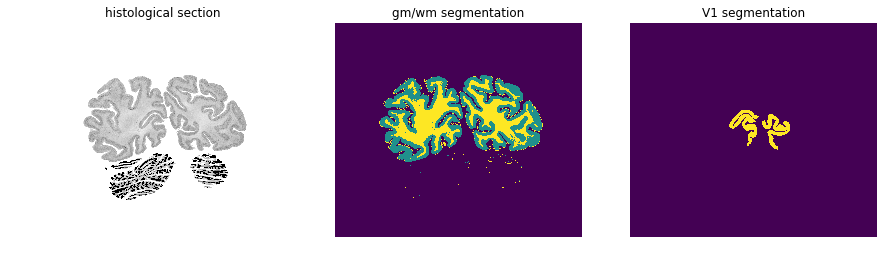

In [4]:
#load and display section and label
img = imageio.imread('data/sections/B20_1021.png')
mask_v1 = imageio.imread('data/masks_v1/B20_1021_v1.png')
mask_gmwm = imageio.imread('data/masks_gmwm/B20_1021_gmwm.png')

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("histological section")
axes[1].imshow(mask_gmwm)
axes[1].set_title("gm/wm segmentation")
axes[2].imshow(mask_v1)
axes[2].set_title("V1 segmentation")
for ax in axes:
    ax.axis("off")

# 1. Prepare data for training
**Challenge**: Histological sections are too large to process at once during training:
- GPU memory too small,
- Effective number of training samples too low

**Solution**: Crop small patches from input images and use for training

*Choices for patch sampling*:
- How large should the input be?
    - Trade-off between efficiency (shared computations for convolutions for large inputs) and variability of data (many small inputs show more different data than one large input)
    - Input patches need to show relevant context
    - Minimal input size may be limited by choice of network architecture (receptivel field - more on that later!)
    - Here, patch size of 256x256px is chosen. 256x256px at 20um per pixel shows 5x5mm of tissue. Sufficient for gray/white matter segmentation
- How many patches should be sampled?
    - As many as possible! Here, patches are computed beforehand (reproducible and faster), but random sampling during training is also possible and increases the variability of the training data
- Where should the patches be sampled from?
    - From the interesting parts of the image!
    - E.g., higher sampling rate from cortex and white matter than background might be beneficial
    - Here, patches were sampled such that each class is represented evenly in the dataset (possible improvement: sample less patches from background class, because it is very easy to learn)

In [5]:
# split available sections in train/val and test sections
imgs = sorted(glob.glob(sections_fname.format('*')))
train_imgs = []
test_imgs = []
val_imgs = []
for i, img in enumerate(imgs):
    if i%6 in (0,1,3,4):
        train_imgs.append(img)
    elif i%6 == 2:
        val_imgs.append(img)
    else:
        test_imgs.append(img)
print('Number of train/val/test images: {}/{}/{}'.format(len(train_imgs),len(val_imgs),len(test_imgs)))

train_sections = get_section_no(train_imgs)
val_sections = get_section_no(val_imgs)
test_sections = get_section_no(test_imgs)
print('Train sections', train_sections)
print('Val sections', val_sections)
print('Test sections', test_sections)

Number of train/val/test images: 26/7/6
Train sections ['0061', '0121', '0241', '0301', '0421', '0481', '0601', '0661', '0781', '0841', '0961', '1021', '1141', '1201', '1321', '1381', '1501', '1561', '1681', '1741', '1861', '1921', '2041', '2101', '2221', '2281']
Val sections ['0181', '0541', '0901', '1261', '1621', '1980', '2341']
Test sections ['0361', '0721', '1081', '1441', '1801', '2161']


In [54]:
# randomly crop patches from train and val sections
def crop_random_patches(imgs, masks, num, patch_size=(256,256), p=None, label_map=None):
    """Randomly crop patches of patch_size from imgs. 
    Ensures that entire patch is inside image
    
    Args:
        imgs, masks: np.array of shape (num_imgs, h, w) containing images and masks to be cropped
        num: int, number of patches that should be cropped
        patch_size: shape of resulting patches
        p: np.array of shape (num_imgs, h, w), default is None. 
            Probability that a certain element of imgs is selected
        label_map: dictionary mapping values in masks to certain labels 
    Returns:
        patches, labels: np.array of shape (num_patches, patch_size)"""
    # select coordinates of upper left corner of patch
    # entire patch should fit in image
    shape = [imgs.shape[0], imgs.shape[1]-patch_size[0], imgs.shape[2]-patch_size[1]] 
    if p is not None:
        # remove borders from p array, such that elements correspond to sampling probability of center pixel of patch
        slice_h = slice(patch_size[0]//2, p.shape[1]-patch_size[0]//2)
        slice_w = slice(patch_size[1]//2, p.shape[2]-patch_size[1]//2)
        p =p[:,slice_h,slice_w]
        indices = np.random.choice(range(0, shape[0]*shape[1]*shape[2]), size=num, p=p.flatten()/np.sum(p))
    else: # random sampling of coordinates
        indices = np.random.randint(low=0, high=shape[0]*shape[1]*shape[2], size=num)
    coords = np.unravel_index(indices, shape)
    coords = np.array(coords).T  # coords has shape num, 3
    # crop patches from imgs and masks for each selected coordinate
    patches = []
    labels = []
    for coord in coords:
        slice_h = slice(coord[1], coord[1]+patch_size[0])
        slice_w = slice(coord[2], coord[2]+patch_size[1])
        patches.append(imgs[coord[0],slice_h,slice_w])
        if label_map is not None:
            label = np.zeros(patch_size, dtype=np.uint8)
            for k,v in label_map.iteritems():
                label[masks[coord[0],slice_h,slice_w]==k] = v
        else:
            label = masks[coord[0],slice_h, slice_w]
        labels.append(label)
    return patches, labels
    
def get_sampling_weights(masks, label_vals):
    """
    Return matrix with sampling probability for each element in masks, 
    such that each label in masks will be sampled with equal probability
    Args:
        masks: array containing labels
        label_vals: list of label values that should be considered in masks
    """
    # caution, needs a lot of RAM
    # weight matrix, weighing gm/wm/background equally (to ensure equal sampling)
    weights = np.zeros(masks.shape)
    for l in label_vals:
        binary_mask = masks == l
        p = 1./np.sum(binary_mask)
        weights[binary_mask] = p
    weights = weights / np.sum(weights)
    return weights

def calculate_patch_dataset(sections, sections_fname, masks_fname, num_patches, label_map):
    # load images
    masks = np.array([imageio.imread(masks_fname.format(sec)) for sec in sections])
    imgs = np.array([imageio.imread(sections_fname.format(sec)) for sec in sections])
    # ensure equal sampling of all classes
    sampling_weights = get_sampling_weights(masks, label_vals=label_map.keys()) 
    patches, labels = crop_random_patches(imgs, masks, num_patches, p=sampling_weights, label_map=label_map)

    # prepare for use as training dataset
    X = np.expand_dims(np.array(patches), 3)
    Y = np.expand_dims(np.array(labels), 3)
    return X, Y

# -- caution, calculating weights and datasets needs a lot of RAM
# -- if this step runs out of memory, set weights = None, or use precomputed patches
np.random.seed(42) # get reproducible datasets
# sample training dataset
X_train, Y_train = calculate_patch_dataset(sections=train_sections[15:16], sections_fname=sections_fname, masks_fname=masks_gmwm_fname,
                       num_patches=10, label_map={0:0, 128:1, 255:2})
np.savez(os.path.join(data_dir, "train.npz"), X=X_train, Y=Y_train)
# sample validation dataset
X_val, Y_val = calculate_patch_dataset(sections=val_sections[5:6], sections_fname=sections_fname, masks_fname=masks_gmwm_fname,
                       num_patches=10, label_map={0:0, 128:1, 255:2})
np.savez(os.path.join(data_dir, "val.npz"), X=X_val, Y=Y_val)

In [63]:
# load precomputed train patches
res = np.load(os.path.join(data_dir, "train.npz"))
X_train = res['X']
Y_train = res['Y']
res.close()

# load precomputed val patches
res = np.load(os.path.join(data_dir, "val.npz"))
X_val = res['X']
Y_val = res['Y']
res.close()

Train dataset shape (n_samples, height, width, n_channels): (10, 256, 256, 1)
Val dataset shape (n_samples, height, width, n_channels): (10, 256, 256, 1)


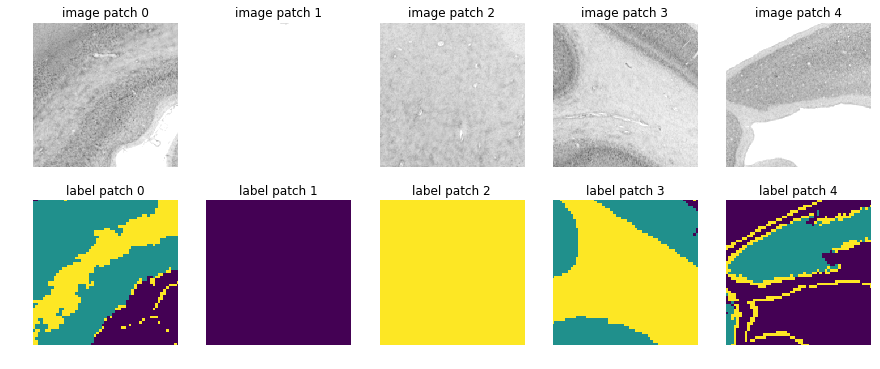

In [64]:
print("Train dataset shape (n_samples, height, width, n_channels): {}".format(X_train.shape))
print("Val dataset shape (n_samples, height, width, n_channels): {}".format(X_val.shape))

# visualize image and label patches
fig, axes = plt.subplots(2,5, figsize=(15,6))
for i,ax in enumerate(axes[0]):
    ax.imshow(X_train[i,:,:,0], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    ax.set_title('image patch {}'.format(i))
for i,ax in enumerate(axes[1]):
    ax.imshow(Y_train[i,:,:,0], vmin=0, vmax=2)
    ax.axis('off')
    ax.set_title('label patch {}'.format(i))


# 2. U-Net architecture for image segmentation
- Neural network for segmentation of large images should be memory-efficient, to enable training with large batch sizes
- U-Net is good choice for segmentation (Ronneberger, 2015)
    - Fully-convolutional, allows tiled prediction of very large images
    - Downsampling branch consisting of blocks of two convolutions and a pooling layer
    - Upsampling branch consisting of an upsampling layer and two convolutions

<img src="files/u-net-architecture.png" style="width:600px">

*Choices for design of custom U-Net*:
- How many blocks? How many convolutions per block? What filter size? Etc...
    - Original U-net architecture is a good starting point, but might not be optimal
    - *Receptive field* is important. This determines how many pixels the network "sees" for the prediction of one pixel. The receptive field is increased by pooling layers and convolutional layers
   
**Important**: If tiled segmentation of a large image is desired, only *valid* convolutions should be used 
- Otherwise, predictions at the borders of the image patches are not correct
- This results in a smaller output size than input size
- Groundtruth labels need to be cropped to the smaller output size when calculating performance metrics


In [65]:
def crop_to_shape_tensor(input_tensor, template_tensor):
    """Crop input_tensor to the shape of template_tensor by applying a cropping2D layer.
    Throw ValueError if template_tensor has a larger size than input_tensor
    
    Args:
        input_tensor: Tensor with shape attribute
        template_tensor: Tensor with shape attribute
    """
    from_shape = np.array(input_tensor.shape.as_list()[1:3])
    to_shape = np.array(template_tensor.shape.as_list()[1:3])
    if np.any(to_shape > from_shape):
        raise ValueError("template_tensor is larger than input_tensor with shapes {} and {}".format(to_shape, from_shape))
    # crop from left/top
    crop1 = np.floor((from_shape-to_shape)/2.).astype(int)
    # crop from right/bottom
    crop2 = np.ceil((from_shape-to_shape)/2.).astype(int)
    cropped_tensor = Cropping2D(cropping=((crop1[0], crop2[0]), (crop1[1], crop2[1])))(input_tensor)
    return cropped_tensor

def crop_to_shape(arr, shape):
    """Crop arr to the shape of template_arr.
    Throw ValueError if shape is larger than arr.shape
    
    Args:
        arr: np.array with shape (., h, w, .)
        shape: desired shape (h,w)
    """
    from_shape = np.array(arr.shape[1:3])
    to_shape = np.array(shape)
    if np.any(to_shape > from_shape):
        raise ValueError('shape is larger than arr.shape with {} {}'.format(to_shape, from_shape))
    crop = np.floor((from_shape-to_shape)/2.).astype(np.uint8)
    return arr[:,crop[0]:shape[0]+crop[0],crop[1]:shape[1]+crop[1]]
    

In [66]:
# U-Net definition
def u_net(input_tensor):
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(input_tensor)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
 
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='valid')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='valid')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    # due to border pixel loss, conv3 is larger than up5 - crop conv3 to shape of up5 to concatenate
    crop3 = crop_to_shape_tensor(conv3, up5)
    conc5 = Concatenate(axis=3)([up5, crop3])
    conv5 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(conc5)
    conv5 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    crop2 = crop_to_shape_tensor(conv2, up6)
    conc6 = Concatenate(axis=3)([up6, crop2])
    conv6 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(conc6)
    conv6 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    crop1 = crop_to_shape_tensor(conv1, up7)
    conc7 = Concatenate(axis=3)([up7, crop1])
    conv7 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(conc7)
    conv7 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(conv7)

    output_tensor = Convolution2D(3, (1, 1), activation='softmax')(conv7)

    return keras.models.Model(input=[input_tensor], output=output_tensor)
    
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 252, 252, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 126, 126, 32) 0           conv2d_2[0][0]                   
_____________________________________

/home/hannah/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`


In [6]:
# receptive size of this model
# TODO get core from christian for this!

# 3. Neural network training 
*Training hyperparameters*:
- Optimizer: SGD with learning rate 0.001, momentum 0.9 (other choices are e.g. Adam optimizer)
- Number of iterations: 2 epochs with batch size 32
- Metric: crossentropy during training and accuracy during evaluation (other choices for segmentation are e.g.  Dice/F1 score)
- Input data is centered to mean 0 and stddev 1
- **Data augmentation**: currently none, more on that later!

In [67]:
# crop groundtruth labels to fit to the smaller output size of the model (due to only 'valid' convolutions)
Y_train_cropped = crop_to_shape(Y_train, model.output.shape.as_list()[1:3])
Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])
print("Shape before cropping: {}. Shape after cropping: {}.".format(Y_train.shape, Y_train_cropped.shape))

# create generator for batches that centers mean and std deviation of training data
datagen = ImageDataGenerator(featurewise_center=True)
datagen.fit(X_train)

Shape before cropping: (10, 256, 256, 1). Shape after cropping: (10, 164, 164, 1).


In [68]:
# parameters for training
lr = 0.001
momentum = 0.9
epochs = 4
batch_size = 1
model_name = 'my_model.hdf5'

# prepare model for training
sgd = SGD(lr=lr, momentum=momentum, nesterov=True)

# use accuracy function from current Keras master, function in keras-2 release does not work as expected for segmentation
def sparse_categorical_accuracy(y_true, y_pred):
    import keras.backend as K
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[sparse_categorical_accuracy] )

# train model
history = model.fit_generator(datagen.flow(X_train, Y_train_cropped, batch_size=batch_size),
                             steps_per_epoch=1, #X_train.shape[0]//batch_size, 
                              epochs=epochs, verbose=2,
                             validation_data=(X_val, Y_val_cropped))

# save model   
model.save(model_name)



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/4
 - 5s - loss: 0.9758 - sparse_categorical_accuracy: 0.5402 - val_loss: 2.0361 - val_sparse_categorical_accuracy: 0.1931
Epoch 2/4
 - 3s - loss: 1.1745 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 10.4075 - val_sparse_categorical_accuracy: 0.3197
Epoch 3/4
 - 3s - loss: 0.9429 - sparse_categorical_accuracy: 0.5815 - val_loss: 10.9479 - val_sparse_categorical_accuracy: 0.3197
Epoch 4/4
 - 4s - loss: 0.0332 - sparse_categorical_accuracy: 1.0000 - val_loss: 10.9644 - val_sparse_categorical_accuracy: 0.3197


Plot progress of train and val loss

In [69]:
print(history.history.keys())

['sparse_categorical_accuracy', 'loss', 'val_sparse_categorical_accuracy', 'val_loss']


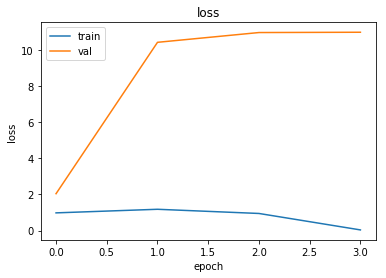

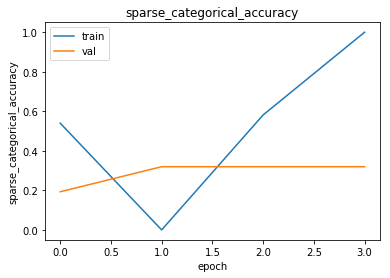

In [70]:
def plot_history(history, key='loss'):
    # summarize history for accuracy
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title(key)
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history, key='loss')
plot_history(history, key='sparse_categorical_accuracy')

# Evaluate model
Evaluatiom on whole slide histological images
- if fits in memory, can predict at once, otherwise need to do patch-wise prediction (with slightly overlapping patches due to pixel loss during valid convolutions)
- need to create model with correct input size input sizes to evaluate large images and load saved weights

In [72]:
# recreate unet model with larger input size
input_shape = (255,255,1)
input_tensor = Input(shape=input_shape)
eval_model = u_net(input_tensor)
eval_model.load_weights(model_name)

print("For input shape {} the output shape is {}".format(eval_model.input_shape, eval_model.output_shape)) 

/home/hannah/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`


For input shape (None, 255, 255, 1) the output shape is (None, 164, 164, 3)


Text(0.5,0.98,'extracted patches')

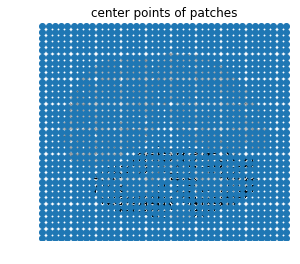

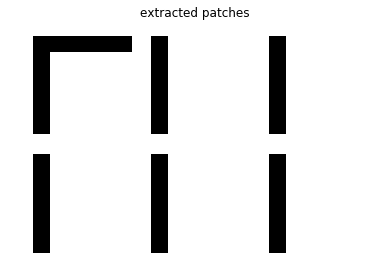

In [73]:
# predict large image by predicting grid of small overlapping images

# functions for creating overlapping patches
def create_grid(img, spacing):
    """Calculate evenly spaced grid over image
    Args:
        img: array with shape (h,w)
        spacing: int
    Returns:
        list of tuples denoting the coordinate of each grid point
    """
    xx, yy = np.meshgrid(range(spacing//2, img.shape[0], spacing), range(spacing//2, img.shape[1], spacing))
    return np.array((xx.ravel(), yy.ravel())).T

def sample_from_coords(img, coords, patch_shape, pad=0):
    """Sample patches from coords
    Args:
        img: array with shape (h,w)
        coords: list of tuples denoting the center coordinate of each patch
        patch_shape: size of patches that should be sampled
        pad: int, padding value that is added if patches exceed image size
    """
    # pad image with padding value to make cropping easier
    pad_value = max(patch_shape)
    img_padded = np.zeros(np.array(img.shape)+np.array([pad_value*2, pad_value*2]))
    img_padded[pad_value:pad_value+img.shape[0],pad_value:pad_value+img.shape[1]] = img

    crops = []
    offset = np.array(patch_shape)//2
    for coord in coords:
        coord = np.array(coord)
        # coord is center point of crop, coord-offset is upper right corner of crop in img,
        # coord-offset+pad_value is upper right corner in img_padded
        ur = coord - offset + pad_value
        crop = img_padded[ur[0]:ur[0]+patch_shape[0],ur[1]:ur[1]+patch_shape[1]]
        crops.append(crop)
    return crops

# load image to predict
X_test = imageio.imread(sections_fname.format(test_sections[4]))
Y_test = imageio.imread(masks_gmwm_fname.format(test_sections[4]))

# create slightly overlapping patches from whole slide section
grid = create_grid(X_test, spacing=eval_model.output_shape[1])
patches = sample_from_coords(X_test, grid, patch_shape=eval_model.input_shape[1:3])

# plot grid on image
fig = plt.figure()
plt.imshow(X_test, cmap='gray')
plt.plot(grid[:,1], grid[:,0], 'o')
plt.axis('off')
plt.title('center points of patches')

# plot patches
fig, axes = plt.subplots(2,3)
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')
    ax.imshow(patches[i], cmap='gray')
plt.suptitle('extracted patches')

In [76]:
pred.shape

(1, 164, 164, 3)

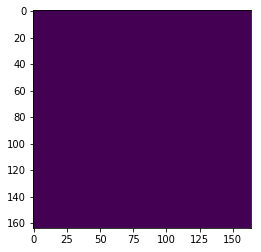

In [78]:
plt.imshow(np.argmax(pred, axis=3)[0], vmin=0, vmax=2)

In [13]:
eval_model.predict?


In [74]:
pred = eval_model.predict(np.expand_dims(np.expand_dims(patches[0], 0),3))

In [15]:
patches_pred = eval_model.predict(np.expand_dims(np.array(patches), 3), batch_size=1)


KeyboardInterrupt: 

In [ ]:
    eval_model.

In [ ]:

Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])

In [ ]:
model.predict(np.expand_dims(np.expand_dims(X_test, axis=0), axis=3))

In [ ]:
#test_score = model.evaluate(X_test_pet, Y_test_pet)
#print("Test :", test_score)

In [ ]:
model.evaluate?

In [ ]:
tf.__version__

# Improve performance with data augmentation

In [ ]:
import tensorflow as tf

# Other ideas for improving performance

In [ ]:
keras.__version__

# What did the model learn? Saliency analysis

In [16]:
range(1,1000, 100)

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]

V1 DOI DOI: 10.25493/DGEZ-Q93
https://www.humanbrainproject.eu/en/explore-the-brain/search/?q=deep%20learning&facet_type[0]=Dataset#Dataset/696d6062-3b86-498f-9ca6-e4d67b433396